### Prueba implementación Saliency y Activation Maps

Visualizamos cómo variaciones en los parámetros del modelo físico
impactan en las unidades del espacio latente.

Para ello comenzamos implementando saliency maps, para entender cómo las variaciones a nivel pixels. 

In [1]:
# Comenzamos generando un modelo y caragando los pesos 
# desde la corrida de SSA

import tensorflow as tf
#import tensorflow._api.v2.compat.v1 as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

#tf.disable_v2_behavior()

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,3)), 
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(4, (4, 4), strides=2, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Flatten(),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            #layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            #layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            
                                            layers.Reshape(target_shape=(10,10,4)),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(4, (4, 4), strides=2, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.Conv2D(3, (4, 4), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

2022-04-06 18:44:15.189933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 18:44:15.189969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
import os
latent_dim = 4

# Get weights path
rel_path = os.path.join(os.getcwd(), "../../results")
file_name = f"weights_lat_{latent_dim}_ssa_two_layer_ngi.h5"
weights_path = os.path.join(rel_path, file_name)

# Load model with weights
model = ConvAutoencoder(4)
model.build(input_shape=(16000,30,30,3))
model.load_weights(weights_path)

Con el modelo entrenado, pasamos imágenes por el encoder y observamos la salida.

(-1.0, 1.0)

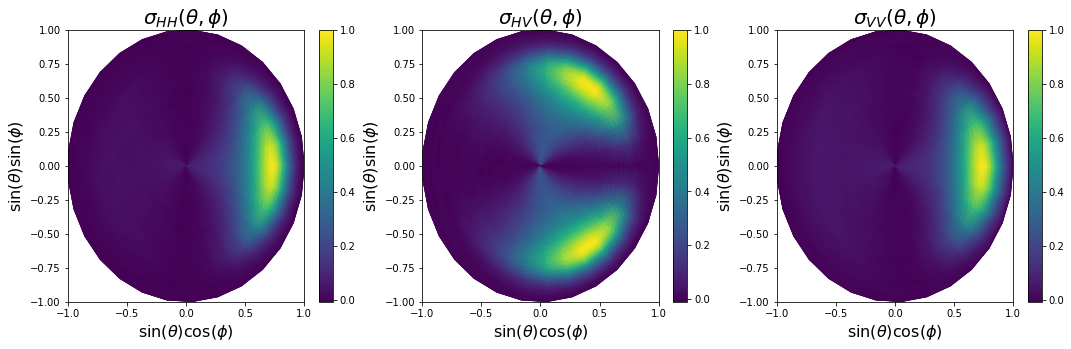

In [16]:
import pickle

from matplotlib import pyplot as plt
import numpy as np

# Prepare some input images
file_path = folder = os.getcwd().split('/')[:-2]
file_name = "results/SSA_tl_test_set.pkl"
file_path = os.path.join("/".join(folder), file_name)

with open(file_path, "rb") as f:
    sigma_test = pickle.load(f)

# Visualize random test element
rng = np.random.default_rng()
idx = rng.integers(sigma_test.shape[0])
img = sigma_test[idx, :, :, :]

# Plot domain
# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi / \
    180, np.linspace(0, 360, 30)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, img[:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal HV
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(kx, ky, img[:,:,1],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(1, 3, 3)
c = ax.pcolormesh(kx, ky, img[:,:,2],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))    


In [27]:
# Create score object to select outputs
#from tf_keras_vis.utils.scores import CategoricalScore
from functools import partial    

def score_function(output, l_dim):
    return output[:, l_dim]

In [35]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model.encoder)

# Generate saliency map
saliency_map = np.array([saliency(partial(score_function, l_dim=l), seed_input=img)[0,:,:] 
                        for l in range(latent_dim)])
saliency_map.shape

(4, 30, 30)

(-1.0, 1.0)

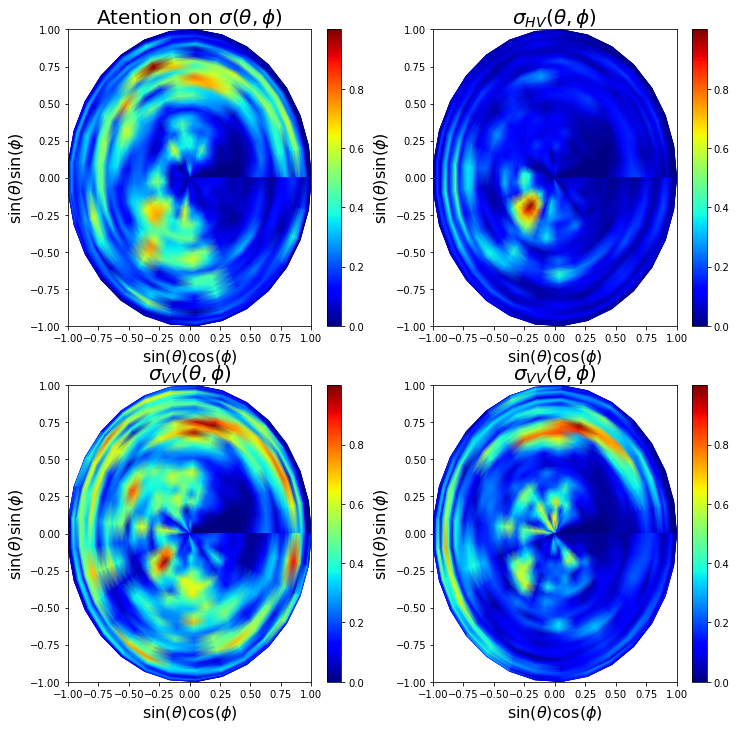

In [38]:
fig = plt.figure(figsize=(12, 12))
# Canal HH
ax = plt.subplot(2, 2, 1)
c = ax.pcolormesh(kx, ky, saliency_map[0], cmap='jet',shading = 'gouraud')
plt.title(r'Atention on $\sigma(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

#Canal HV
ax = plt.subplot(2, 2, 2)
c = ax.pcolormesh(kx, ky, saliency_map[1], cmap='jet',shading = 'gouraud')
plt.title(r'$\sigma_{HV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(2, 2, 3)
c = ax.pcolormesh(kx, ky, saliency_map[2], cmap='jet',shading = 'gouraud')
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))   

# Canal VV
ax = plt.subplot(2, 2, 4)
c = ax.pcolormesh(kx, ky, saliency_map[3], cmap='jet',shading = 'gouraud')
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))  